## Logistic Regression, Decision Tree, Feature Selection, Prediction, Data Processing

In [1]:
%%time
# try out dplyr python version
from dfply import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
df = pd.read_excel("KickstarterData_Facts-1.xlsx")
df >> head(3)

Wall time: 2.34 s


,Donate ID,Donate Date,Gender,Deposit Amount,Preferred Color of Device,Ice Cream Products Consumed Per Week,Favorite Flavor Of Ice Cream,Donated To Kick Starter Before,Household Income,Do you own a Keurig,How many desserts do you eat a week,Purchased
0,1,2019-07-01,female,100,white,4,vanilla,yes,<50K,yes,7,0
1,2,2019-07-01,female,100,blue,5,vanilla,yes,<50K,yes,5,1
2,3,2019-07-01,female,100,silver,6,vanilla,yes,<50K,yes,6,1


**Context**

We have a datasets that stores certain information of customers/donators who had donated to our future product (ice cream machine),deposit amount shows their amount of donation, the source of the information are from surveys. Our topic of interest, is last column **purchased**, 1 stands for purchased, 0 stands for did not purchase. We want to find out what factors are the key ones that had by the donators who decided to buy. Other column names are pretty self-explantory. Note that default deposit amount is $100.

---

To implement dfply to wrangle the data in a R-tidyverse way, I would need to convert the column name into a Hadley Wickham's tidy form, which allows no space in column names.

In [2]:
# re-format column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

Removed donate_Id and donate_date since they are index.

In [3]:
# remove certain variables
df1 = df >> select(~X.donate_id, ~X.donate_date)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   gender                                10000 non-null  object
 1   deposit_amount                        10000 non-null  int64 
 2   preferred_color_of_device             10000 non-null  object
 3   ice_cream_products_consumed_per_week  10000 non-null  int64 
 4   favorite_flavor_of_ice_cream          10000 non-null  object
 5   donated_to_kick_starter_before        10000 non-null  object
 6   household_income                      10000 non-null  object
 7   do_you_own_a_keurig                   10000 non-null  object
 8   how_many_desserts_do_you_eat_a_week   10000 non-null  int64 
 9   purchased                             10000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 781.4+ KB


In [4]:
# checking if there's missing values
df1.isnull().sum()

gender                                  0
deposit_amount                          0
preferred_color_of_device               0
ice_cream_products_consumed_per_week    0
favorite_flavor_of_ice_cream            0
donated_to_kick_starter_before          0
household_income                        0
do_you_own_a_keurig                     0
how_many_desserts_do_you_eat_a_week     0
purchased                               0
dtype: int64

In [5]:
df_noid = df.drop('donate_id', 1)

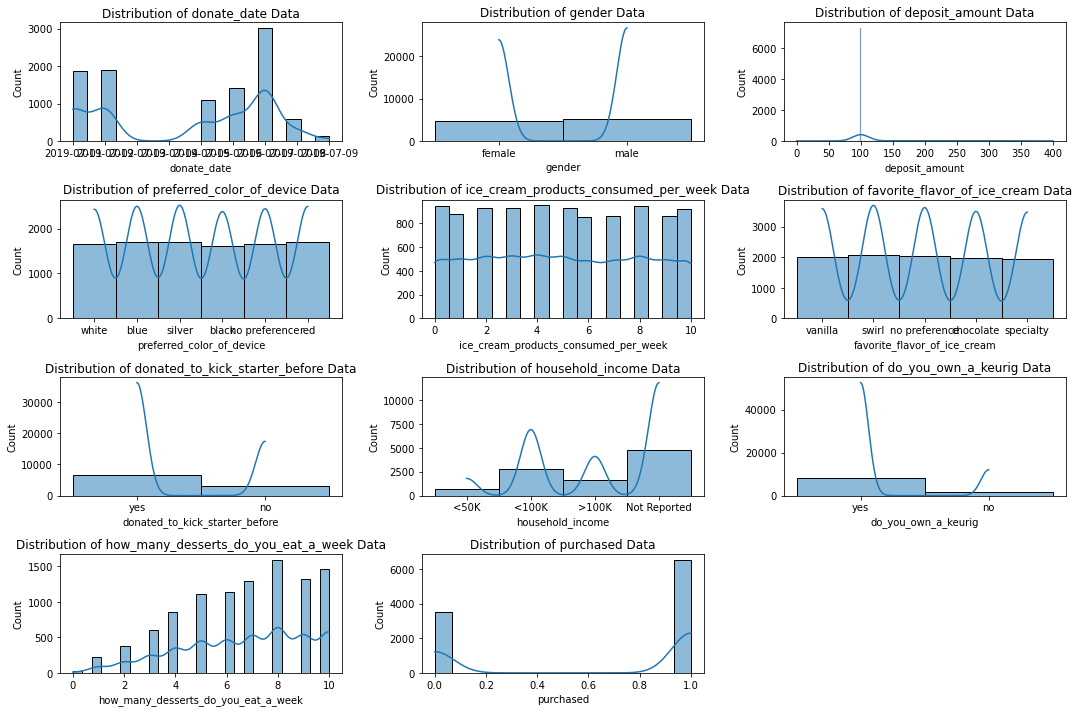

In [6]:
# plot distributions for all variables
plt.figure(figsize=(15,10))
for i,col in enumerate(df_noid.columns,1):
    plt.subplot(4,3,i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(df[col],kde=True)
    plt.tight_layout()
    plt.plot()

Wall time: 2.47 s


<Figure size 1080x720 with 0 Axes>

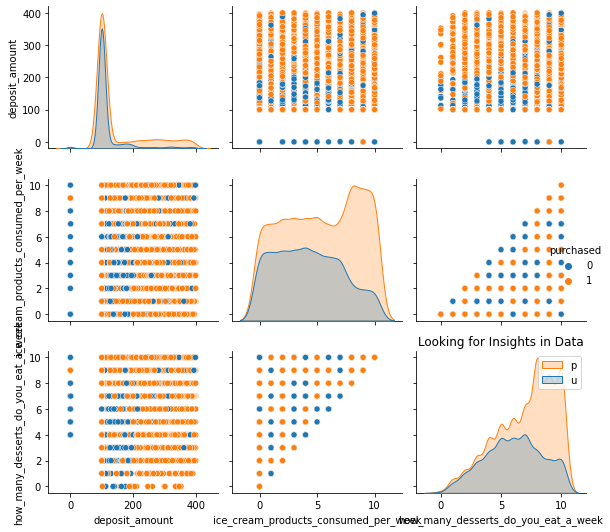

In [7]:
%%time
plt.figure(figsize=(15,10))
sns.pairplot(df_noid,hue="purchased")
plt.title("Looking for Insights in Data")
plt.plot()
plt.legend("purchased")
plt.tight_layout()

##### Finding from pairplot
- donators who have higher desserts comsumption per week (7) are more likely to purchase
- donators who eat more than 6 ice creams per week are more likely to buy the machine than those who don't
- donators who put down more than $200 demosit amount are more likely to purchase the machine 

Note that there is a **collinearity** between ice cream consumption and dessert consumption since dessert includes ice cream

In [8]:
# add a new indicator column specifying if donator donates more than default value $100
conditions = [
    (df1['deposit_amount'] == 0),
    (df1['deposit_amount'] == 100),
    (df1['deposit_amount'] > 100)
    ]

# 1 indicating donating over than default value.
values = [0, 1, 2]

# making new indicator column for deposit amount
df1['deposit_over_100']=np.select(conditions, values)
df1.head()

,gender,deposit_amount,preferred_color_of_device,ice_cream_products_consumed_per_week,favorite_flavor_of_ice_cream,donated_to_kick_starter_before,household_income,do_you_own_a_keurig,how_many_desserts_do_you_eat_a_week,purchased,deposit_over_100
0,female,100,white,4,vanilla,yes,<50K,yes,7,0,1
1,female,100,blue,5,vanilla,yes,<50K,yes,5,1,1
2,female,100,silver,6,vanilla,yes,<50K,yes,6,1,1
3,female,100,silver,5,vanilla,yes,<50K,yes,5,1,1
4,male,100,white,1,vanilla,yes,<50K,yes,7,0,1


In [9]:
# donators who donated more than default deposit who purchased
df1[(df1['deposit_over_100'] == 0)]['purchased'].value_counts(normalize=True)

0    0.925
1    0.075
Name: purchased, dtype: float64

In [10]:
# donators who donated more than default deposit who purchased
df1[(df1['deposit_over_100'] == 1)]['purchased'].value_counts(normalize=True)

1    0.61222
0    0.38778
Name: purchased, dtype: float64

In [11]:
df1[(df1['deposit_over_100'] == 2)]['purchased'].value_counts(normalize=True)

1    0.768154
0    0.231846
Name: purchased, dtype: float64

###### Finding
Donaters who donated more than the default value $100 has more likelyhood of purchasing the machine in the end.

### Assumption check
##### Assumptions of Logistic Regression
1. binary outcome
2. the observations are independent
3. multicollinearity
4. extreme outliers
5. The Sample Size is Sufficiently Large

In [12]:
# 1. binary outcome check
df['purchased'].value_counts()

1    6513
0    3487
Name: purchased, dtype: int64

<AxesSubplot:>

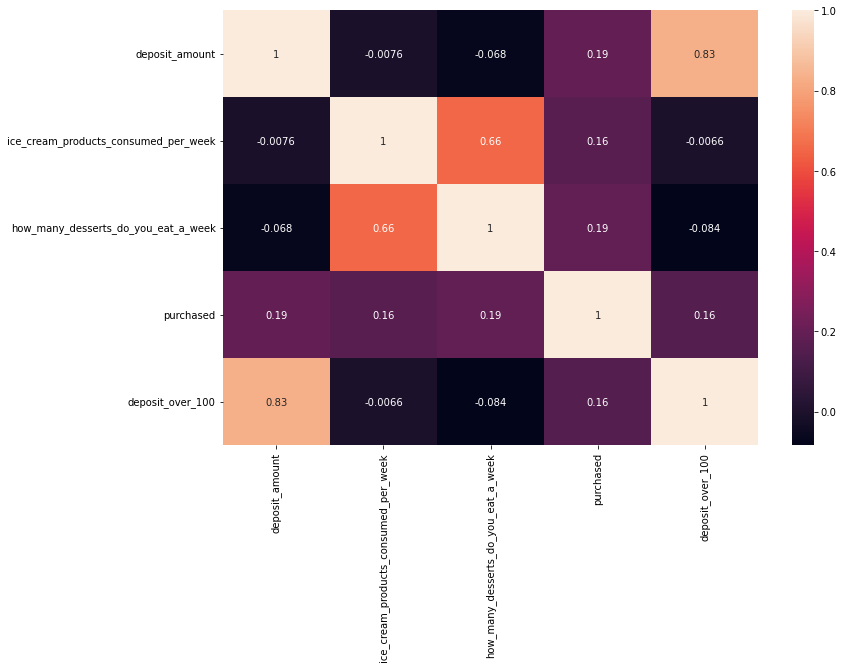

In [13]:
# 2. since each sample point indicates one individual survey, there is no dependence concern in this case
# 3. multicollinearity would be tested after the model - fitting
fig, ax = plt.subplots(figsize = (12, 8))
sns.heatmap(df1.corr(), annot = True)

##### multicolinarity is found:
1. between [# of Ice cream] and [# of desserts] comsumed each week, which makes perfect sense, since dessert includes ice cream
2. between [deposit indicator] and [deposit amount], which makes sense too, since indicator is made based on the amount

In [14]:
df1.columns

Index(['gender', 'deposit_amount', 'preferred_color_of_device',
       'ice_cream_products_consumed_per_week', 'favorite_flavor_of_ice_cream',
       'donated_to_kick_starter_before', 'household_income',
       'do_you_own_a_keurig', 'how_many_desserts_do_you_eat_a_week',
       'purchased', 'deposit_over_100'],
      dtype='object')

In [15]:
# double check if there is missleading rows that have desserts eat a week smaller than ice cream consumed per week
df_count = df1.loc[df1['how_many_desserts_do_you_eat_a_week'] >= df1['ice_cream_products_consumed_per_week']]
df_count.shape[0]

10000

Since dessert number contains ice cream number, our focus is whether customers will purchase the ice cream machine, so I should drop the 'how_many_desserts_do_you_eat_a_week'column to eliminate the colinarity between [# of Ice cream] and [# of desserts] consumed each week.

In [16]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   gender                                10000 non-null  object
 1   deposit_amount                        10000 non-null  int64 
 2   preferred_color_of_device             10000 non-null  object
 3   ice_cream_products_consumed_per_week  10000 non-null  int64 
 4   favorite_flavor_of_ice_cream          10000 non-null  object
 5   donated_to_kick_starter_before        10000 non-null  object
 6   household_income                      10000 non-null  object
 7   do_you_own_a_keurig                   10000 non-null  object
 8   how_many_desserts_do_you_eat_a_week   10000 non-null  int64 
 9   purchased                             10000 non-null  int64 
 10  deposit_over_100                      10000 non-null  int32 
dtypes: int32(1), int64(4), object

In [17]:
# detect outliers
df_numeric = df1.select_dtypes(include = np.number)

df_numeric.describe()

,deposit_amount,ice_cream_products_consumed_per_week,how_many_desserts_do_you_eat_a_week,purchased,deposit_over_100
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,139.515800,4.962300,6.686800,0.651300,1.260400
std,80.483091,3.165293,2.460592,0.476583,0.447897
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,100.000000,2.000000,5.000000,0.000000,1.000000
50%,100.000000,5.000000,7.000000,1.000000,1.000000
75%,119.000000,8.000000,9.000000,1.000000,2.000000
max,400.000000,10.000000,10.000000,1.000000,2.000000


In [18]:
df_numeric = df_numeric.drop('deposit_over_100', 1)

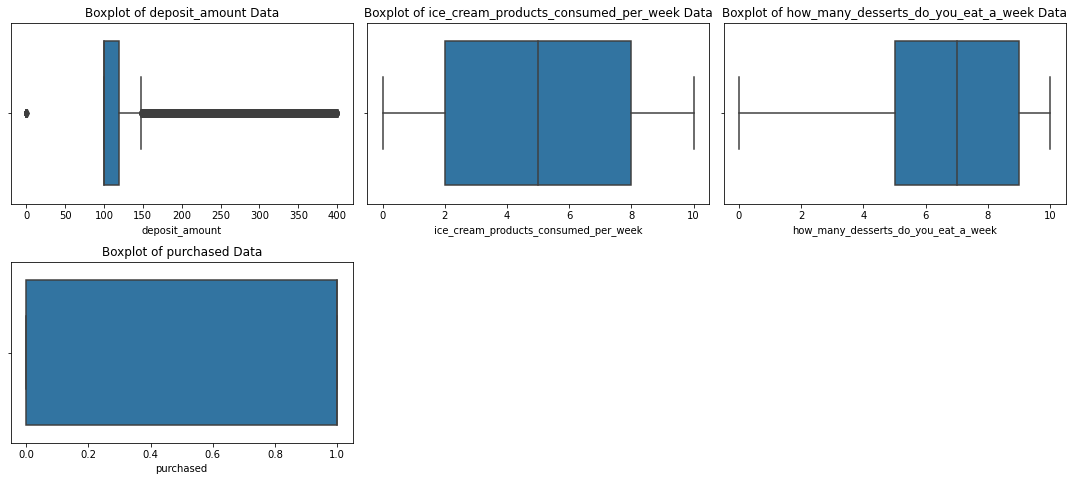

In [19]:
plt.figure(figsize=(15,13))
for i,col in enumerate(df_numeric.columns,1):
    plt.subplot(4,3,i)
    plt.title(f"Boxplot of {col} Data")
    sns.boxplot(df[col])
    plt.tight_layout()
    plt.plot()

Outliers only observed in Deposit amount, however, they are extreme not due to error but natural variantion and the fact that default deposit amount is $100. So I chose to perserve them for future customer segmentation analysis.

### Generalized Linear Regression

In [20]:
# generate dummy variables
df3 = pd.get_dummies(df1)
df3.columns

Index(['deposit_amount', 'ice_cream_products_consumed_per_week',
       'how_many_desserts_do_you_eat_a_week', 'purchased', 'deposit_over_100',
       'gender_female', 'gender_male', 'preferred_color_of_device_black',
       'preferred_color_of_device_blue',
       'preferred_color_of_device_no preference',
       'preferred_color_of_device_red', 'preferred_color_of_device_silver',
       'preferred_color_of_device_white',
       'favorite_flavor_of_ice_cream_chocolate',
       'favorite_flavor_of_ice_cream_no preference',
       'favorite_flavor_of_ice_cream_specialty',
       'favorite_flavor_of_ice_cream_swirl',
       'favorite_flavor_of_ice_cream_vanilla',
       'donated_to_kick_starter_before_no',
       'donated_to_kick_starter_before_yes', 'household_income_<100K',
       'household_income_<50K', 'household_income_>100K',
       'household_income_Not Reported', 'do_you_own_a_keurig_no',
       'do_you_own_a_keurig_yes'],
      dtype='object')

In [21]:
# partition predictor and response
# remove dummy variables that was meant for baseline, and those cause extra collinearity
df_x = df3.drop(['purchased', 'do_you_own_a_keurig_no', 'household_income_<50K', 'household_income_<100K',
       'household_income_Not Reported','favorite_flavor_of_ice_cream_specialty',
       'favorite_flavor_of_ice_cream_swirl',
       'favorite_flavor_of_ice_cream_vanilla','preferred_color_of_device_red', 'preferred_color_of_device_silver',
       'preferred_color_of_device_white',
       'favorite_flavor_of_ice_cream_chocolate','preferred_color_of_device_black',
       'preferred_color_of_device_blue','gender_male', 'deposit_over_100', 'how_many_desserts_do_you_eat_a_week','donated_to_kick_starter_before_no',], 1)

df_y = df3['purchased']

df_x.shape

(10000, 8)

In [22]:
# backward selection for features
import statsmodels.api as sm
def backward_elimination(data, target,significance_level = 0.05):
    features = data.columns.tolist()
    while(len(features)>0):
        features_with_constant = sm.add_constant(data[features])
        p_values = sm.Logit(target, features_with_constant).fit(disp=0).pvalues[1:]
        max_p_value = p_values.max()
        if(max_p_value >= significance_level):
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break 
    return features

feature = backward_elimination(df_x, df_y)
print(feature)

['deposit_amount', 'ice_cream_products_consumed_per_week', 'gender_female', 'preferred_color_of_device_no preference', 'favorite_flavor_of_ice_cream_no preference', 'donated_to_kick_starter_before_yes', 'household_income_>100K']


In [23]:
len(feature)

7

In [24]:
x = df3[feature]
y = df3.purchased

In [25]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 10, stratify = y)

In [26]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

calc_vif(x)

,variables,VIF
0,deposit_amount,3.358215
1,ice_cream_products_consumed_per_week,2.509889
2,gender_female,1.810803
3,preferred_color_of_device_no preference,1.172688
4,favorite_flavor_of_ice_cream_no preference,1.224885
5,donated_to_kick_starter_before_yes,2.868561
6,household_income_>100K,1.275436


VIF result shows no multi-collinearity found.

In [27]:
import statsmodels.api as sm

logr_model = sm.Logit(y_train, x_train) 
logr_fit = logr_model.fit()
print(logr_fit.summary())


Optimization terminated successfully.
         Current function value: 0.391562
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              purchased   No. Observations:                 7500
Model:                          Logit   Df Residuals:                     7493
Method:                           MLE   Df Model:                            6
Date:                Fri, 04 Mar 2022   Pseudo R-squ.:                  0.3944
Time:                        22:43:56   Log-Likelihood:                -2936.7
converged:                       True   LL-Null:                       -4849.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
deposit_amount                              

##### Finding from the output:

- statistical significance found on 'preferred_color_of_device_no preference', 'favorite_flavor_of_ice_cream_no preference', 'household_income_>100K', 'deposit_amount', 'ice_cream_products_consumed_per_week','gender_female'
- strong positives impact found on Househose_income > 100K
- strong negative impact found on preferred_color_of_device_no preference, favorite_flavor_of_ice_cream_no preference

##### Explanation:
1. Customers with higher income (>100k) would be more willing to buy the new product
2. Customers who don't have a preference on ice cream flavor are much less likely to purcahse the ice cream machine, since people who does not have a preference on ice cream flavor are likely to be the ones that don't eat ice cream that often. Customers who don't have a preference colour might decide not to buy it from the beginning.

<Figure size 144x144 with 0 Axes>

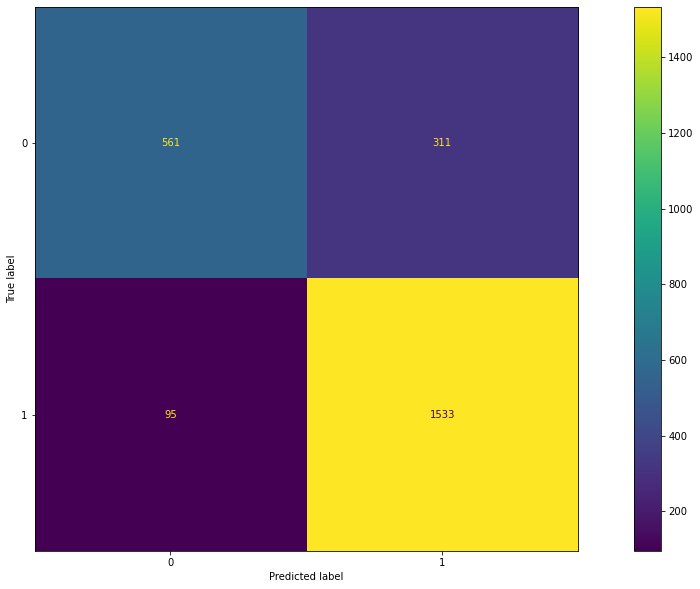

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
lr= LogisticRegression()
model=lr.fit(x_train,y_train)

#view results
model.fit(x_train, y_train)
plt.figure(figsize=(2,2))
plot_confusion_matrix(lr, x_test, y_test)  
plt.show()


##### Strong at predicting Yes, also good at predicting No.
Precision is high, might due to the inbalance data (we have more customers bought than did not buy)

In [29]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(x_train,y_train)

#
y_pred=logreg.predict(x_test)

In [30]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

True Positives: 1533
False Positives: 311
True Negatives: 561
False Negatives: 95


In [31]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix,classification_report, roc_auc_score
print(classification_report(y_test,y_pred, digits = 3))


              precision    recall  f1-score   support

           0      0.855     0.643     0.734       872
           1      0.831     0.942     0.883      1628

    accuracy                          0.838      2500
   macro avg      0.843     0.792     0.809      2500
weighted avg      0.840     0.838     0.831      2500



##### Strong model
1. Overall accuracy is 83.8% Strong performance.
2. Recall is nearly as good as precison, balanced model.

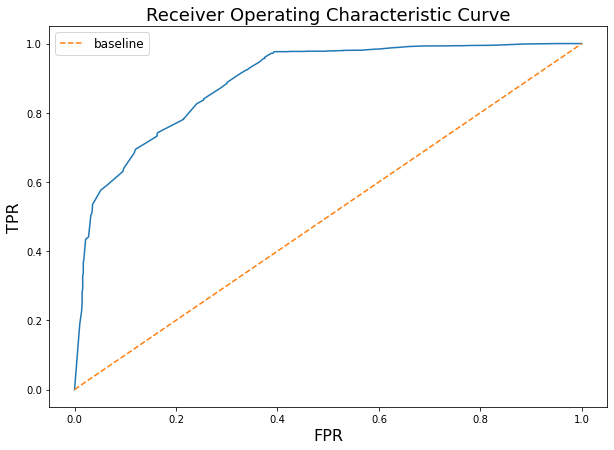

In [32]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
probas = lr.predict_proba(x_test)[:, 1]


def get_preds(threshold, probabilities):
    return [1 if prob > threshold else 0 for prob in probabilities]


roc_values = []
for thresh in np.linspace(0, 1, 100):
    preds = get_preds(thresh, probas)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    roc_values.append([tpr, fpr])
tpr_values, fpr_values = zip(*roc_values)

fig, ax = plt.subplots(figsize=(10,7))
ax.plot(fpr_values, tpr_values)
ax.plot(np.linspace(0, 1, 100),
         np.linspace(0, 1, 100),
         label='baseline',
         linestyle='--')
plt.title('Receiver Operating Characteristic Curve', fontsize=18)
plt.ylabel('TPR', fontsize=16)
plt.xlabel('FPR', fontsize=16)
plt.legend(fontsize=12);

In [33]:
from sklearn.linear_model import LogisticRegression

auc = metrics.roc_auc_score(y_test, y_pred)
print(auc)


0.7924974077497013


### Decision Tree

In [34]:
string_col = df1.select_dtypes(include="object").columns
df1[string_col]=df1[string_col].astype("string")

string_col=df1.select_dtypes("string").columns.to_list()

In [35]:
from sklearn.preprocessing import LabelEncoder

x['purchased'] = y
df_tree = x.apply(LabelEncoder().fit_transform)
df_tree.head()
x

,deposit_amount,ice_cream_products_consumed_per_week,gender_female,preferred_color_of_device_no preference,favorite_flavor_of_ice_cream_no preference,donated_to_kick_starter_before_yes,household_income_>100K,purchased
0,100,4,1,0,0,1,0,0
1,100,5,1,0,0,1,0,1
2,100,6,1,0,0,1,0,1
3,100,5,1,0,0,1,0,1
4,100,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...
9995,100,4,0,0,0,0,0,1
9996,100,6,0,0,1,1,0,0
9997,0,3,0,0,0,1,0,0
9998,0,6,0,0,0,0,0,0


In [36]:
feature_col_tree=df_tree.columns.to_list()
target = 'purchased'
feature_col_tree.remove(target)

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
acc_Dtree=[]
kf=model_selection.StratifiedKFold(n_splits=5)
for fold , (trn_,val_) in enumerate(kf.split(X=df_tree,y=y)):
    
    X_train=df_tree.loc[trn_,feature_col_tree]
    y_train=df_tree.loc[trn_,target]
    
    X_valid=df_tree.loc[val_,feature_col_tree]
    y_valid=df_tree.loc[val_,target]
    
    clf=DecisionTreeClassifier(criterion="entropy")
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_valid)
    print(f"The fold is : {fold} : ")
    print(classification_report(y_valid,y_pred))
    acc=roc_auc_score(y_valid,y_pred)
    acc_Dtree.append(acc)
    print(f"The accuracy for {fold+1} : {acc}")

The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.89      0.73      0.80       698
           1       0.87      0.95      0.91      1302

    accuracy                           0.87      2000
   macro avg       0.88      0.84      0.85      2000
weighted avg       0.87      0.87      0.87      2000

The accuracy for 1 : 0.8407002231523907
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.78      0.73      0.76       698
           1       0.86      0.89      0.88      1302

    accuracy                           0.84      2000
   macro avg       0.82      0.81      0.82      2000
weighted avg       0.84      0.84      0.84      2000

The accuracy for 2 : 0.8133310445908652
The fold is : 2 : 
              precision    recall  f1-score   support

           0       0.74      0.53      0.62       697
           1       0.78      0.90      0.84      1303

    accuracy                           0.77  

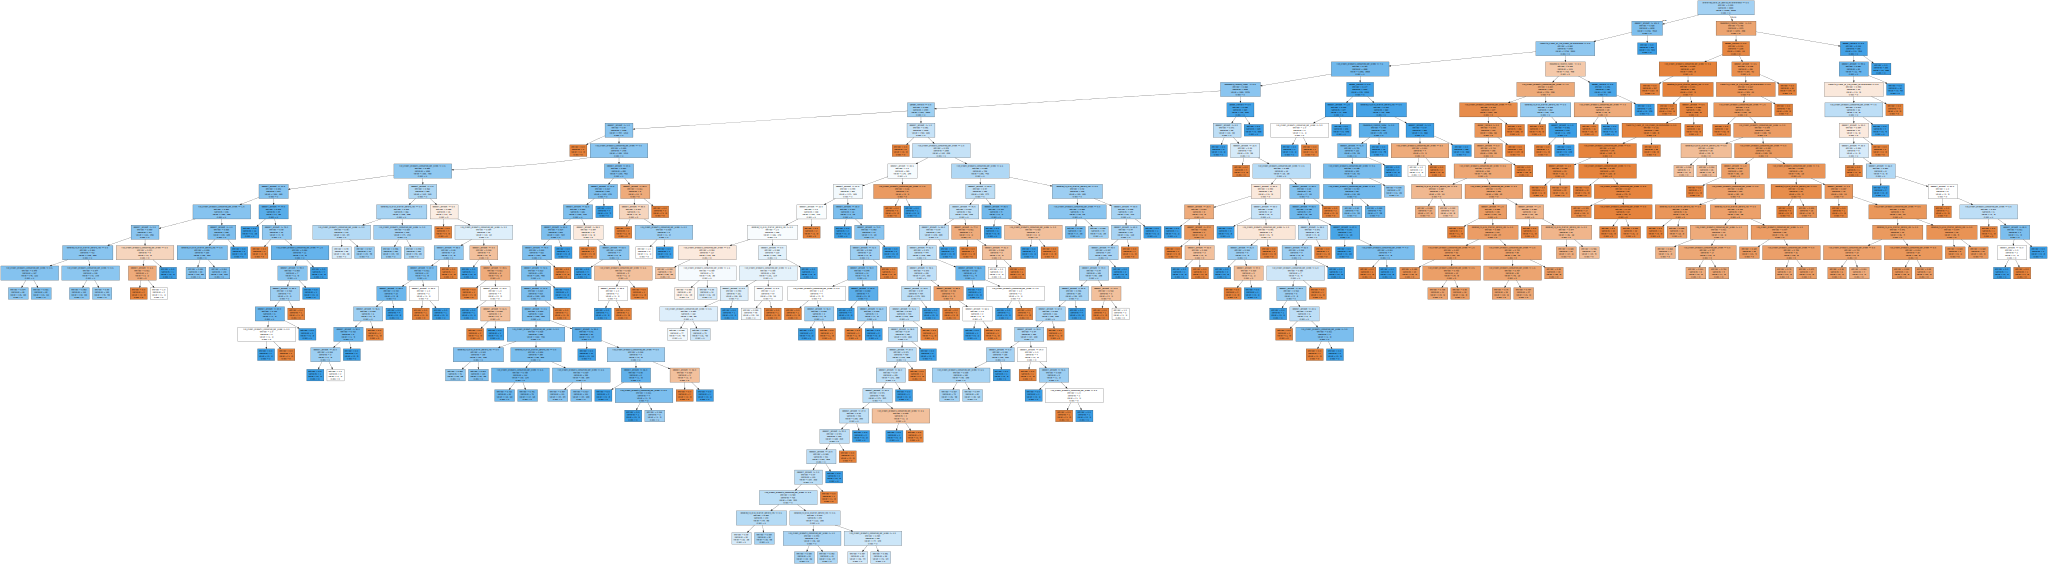

In [38]:
import graphviz
from sklearn import tree

# DOT data
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=feature_col_tree,  
                                class_names=target,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph